#### The purpose of this EDA notebook is the following:
- Better understand the nature of the relationship between the independent variables
- Create an initial model with reasonable economic assumptions that may be dropped in later versions
- Explore methods of imputation for missing variables to provide more data samples
- Avoid linear combinations that might be more difficult to spot in the Bayesian Modeling process
- Establish a reasonable measure of variable importance, which along with correlation plots may inform initial hierarchies
- Create visualizations of poor quality data and also establish probability distributions for the likelihood function

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from rfpimp import *
from rfpimp import plot_corr_heatmap
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
import category_encoders as ce

#### In an effort to generalize for future EDA, 'df' makes it easier to debug

In [2]:
df = pd.read_csv('C:/Users/norri/Desktop/all_ab_data.csv')
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4393 entries, 0 to 4392
Columns: 123 entries, % Dollar Sales by Merch Any Display to Weighted Average Base Price Per Unit
dtypes: float64(107), int64(6), object(10)
memory usage: 4.1+ MB


### The info function above tells us we have three data types and counts of each. The next section will explore those variables in groups.

In [3]:
segment = [var for var in df.columns if df[var].dtype=='O']
print('There are {} categorical variables\n'.format(len(segment)))
print('The categorical variables are :\n\n', segment)
print(df[segment].isnull().sum() + df[segment].isna().sum())
df_cat = df.select_dtypes(include=object)
unique_cats = df_cat.nunique()

# I like this visualization but it needs some tweaking or replacement
# note: write a function because this repetitive plotting could be done in a few lines
# for col in segment:
#     sns.boxplot(y=df_cat.nunique().astype('int32'), x=col, data=df_cat)
#     plt.show()

There are 10 categorical variables

The categorical variables are :

 ['Brand Family Value', 'Brand Value', 'Brewer Value', 'Category Value', 'CONCAT', 'Geography', 'Product', 'Segment Value', 'Time', 'Type Value']
Brand Family Value    1836
Brand Value           4654
Brewer Value           290
Category Value         144
CONCAT                   0
Geography                0
Product                  0
Segment Value         1234
Time                     0
Type Value            2624
dtype: int64


In [4]:
integer = [var for var in df.columns if df[var].dtype=='int64']
print('There are {} integer variables\n'.format(len(integer)))
print('The integer variables are :\n\n', integer)
print(df[integer].isnull().sum())

There are 6 integer variables

The integer variables are :

 ['F81', 'Product Development Index', 'Sum of Dollar Sales Checkout Display', 'Sum of Dollar Sales Outside Display', 'Sum of Dollar Sales Signage and Feature', 'Sum of Dollar Sales Signage, Feature and Display']
F81                                                 0
Product Development Index                           0
Sum of Dollar Sales Checkout Display                0
Sum of Dollar Sales Outside Display                 0
Sum of Dollar Sales Signage and Feature             0
Sum of Dollar Sales Signage, Feature and Display    0
dtype: int64


In [5]:
fp = [var for var in df.columns if df[var].dtype=='float64']
print('There are {} float variables\n'.format(len(fp)))
print('The float variables are :\n\n', fp)
print(df[fp].isnull().sum() + df[fp].isna().sum())

There are 107 float variables

The float variables are :

 ['% Dollar Sales by Merch Any Display', '% Dollar Sales by Merch Any Feature', '% Dollar Sales by Merch Any Merch', '% Dollar Sales by Merch Any Price Reduction', '% Increase in Dollars by Merch Advertised Frequent Shopper', '% Increase in Dollars by Merch Any Display', '% Increase in Dollars by Merch Any Feature', '% Increase in Dollars by Merch Any Merch', '% Increase in Dollars by Merch Any Price Reduction', '% Increase in Dollars by Merch Any Special Pack', '% Increase in Dollars by Merch Display Only', '% Increase in Dollars by Merch Feature and Display', '% Increase in Dollars by Merch Feature and/or Display', '% Increase in Dollars by Merch Feature Only', '% Increase in Dollars by Merch Price Reductions Only', '% Increase in Dollars by Merch Special Pack Only', '% Increase in Units by Merch', '% Increase in Units by Merch Advertised Frequent Shopper', '% Increase in Units by Merch Any Display', '% Increase in Units by Me

### Clearly the float variables contain all the missing data in the dataset. In
### cases like this, dropping the missing values are a trade-off to consider
### against dropping an entire column and losing its input into the model

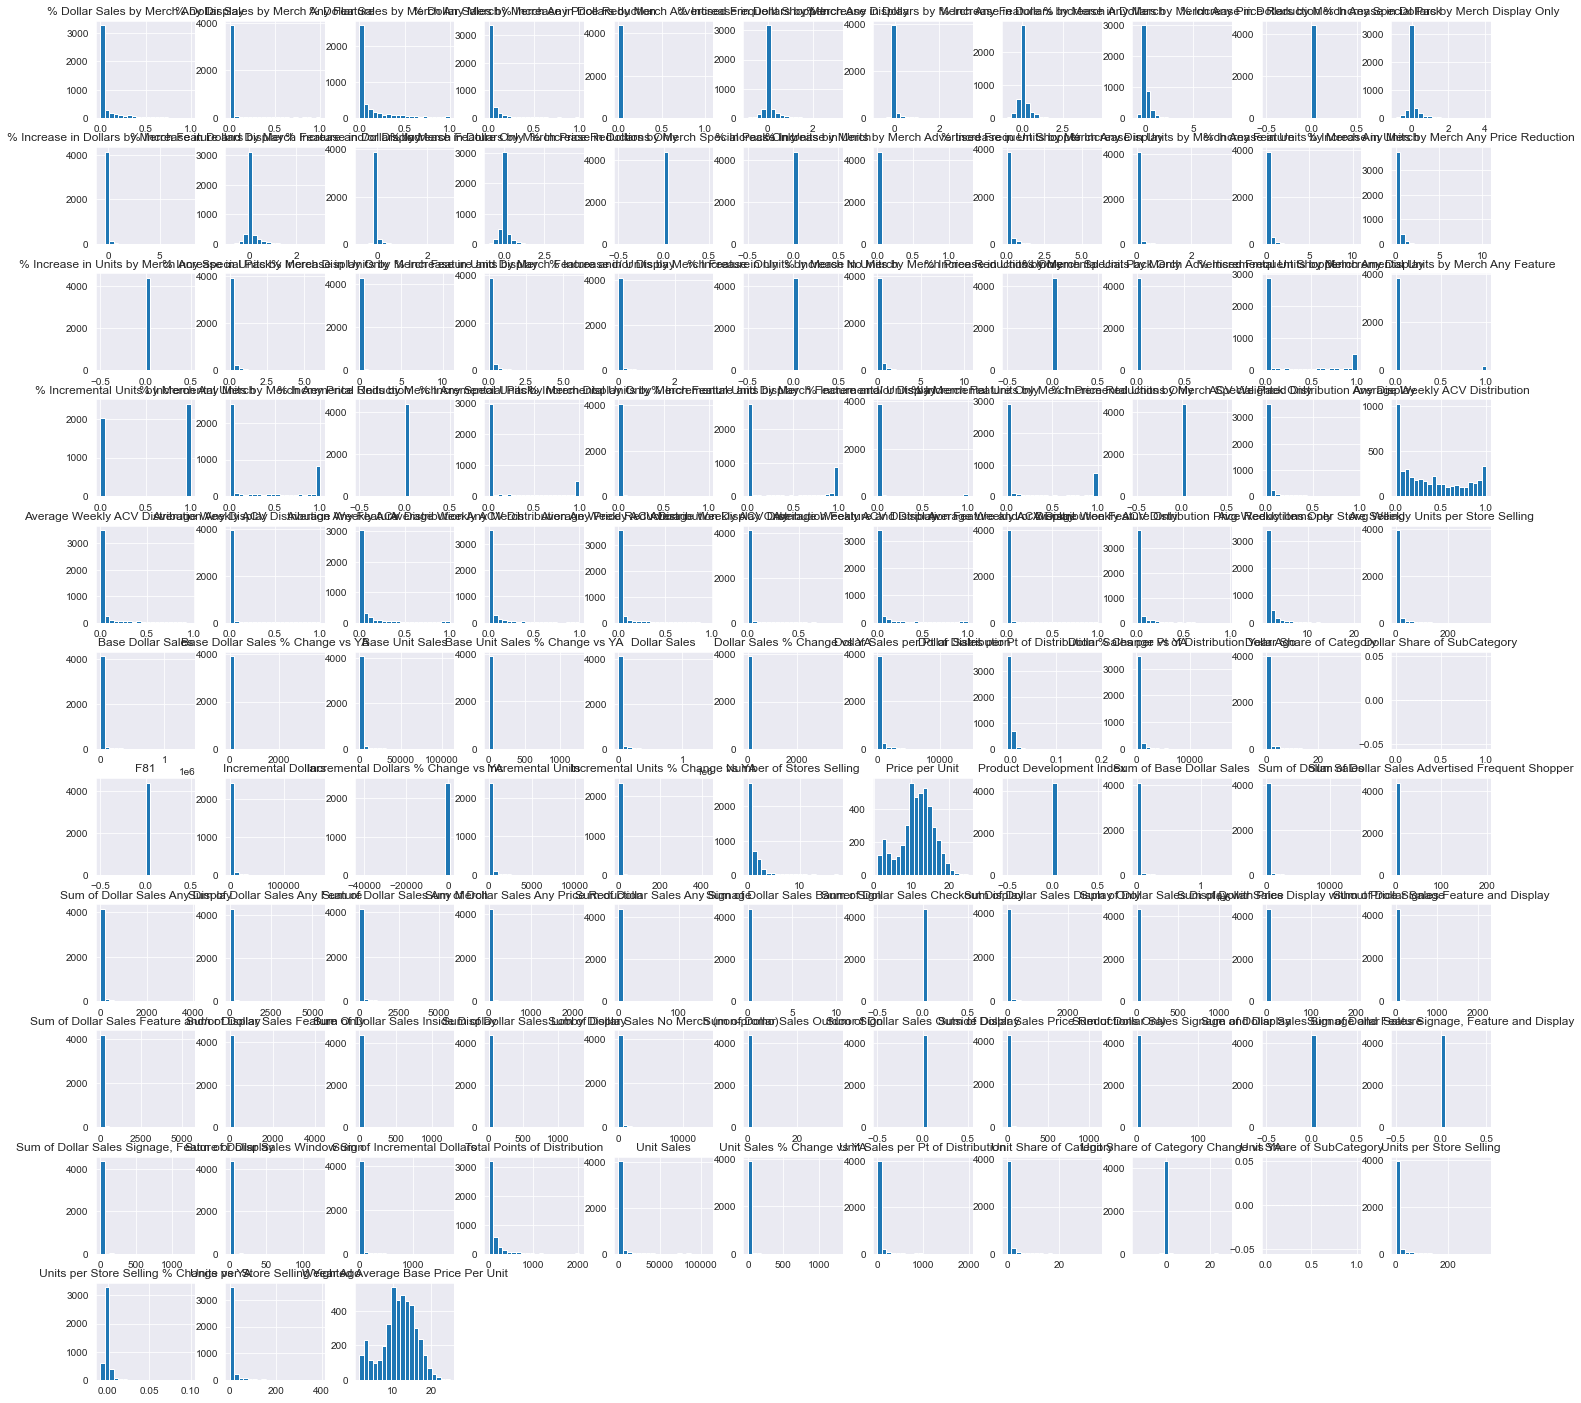

In [6]:
# in addition to the kde plots at the bottom of the notebook, this give some
# idea as to the distributions for the likelihood functions
df.hist(figsize=(25, 25), bins=20)
plt.show()

In [7]:
missing_segment = (df[segment].isnull().sum() / len(df)) * 100
missing_integer = (df[integer].isnull().sum() / len(df)) * 100
missing_float = (df[fp].isnull().sum() / len(df)) * 100
print(missing_segment)
print(missing_integer)
print(missing_float)

Brand Family Value    20.896881
Brand Value           52.970635
Brewer Value           3.300706
Category Value         1.638971
CONCAT                 0.000000
Geography              0.000000
Product                0.000000
Segment Value         14.045072
Time                   0.000000
Type Value            29.865695
dtype: float64
F81                                                 0.0
Product Development Index                           0.0
Sum of Dollar Sales Checkout Display                0.0
Sum of Dollar Sales Outside Display                 0.0
Sum of Dollar Sales Signage and Feature             0.0
Sum of Dollar Sales Signage, Feature and Display    0.0
dtype: float64
% Dollar Sales by Merch Any Display                             0.00000
% Dollar Sales by Merch Any Feature                             0.00000
% Dollar Sales by Merch Any Merch                               0.00000
% Dollar Sales by Merch Any Price Reduction                     0.00000
% Increase in Dollars by M

In [8]:
print('Missing variables check' + ' ' + str((len(integer) + len(fp) +
                                             len(segment) - len(df.T))))
print(df.info())
print(df.describe())

Missing variables check 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4393 entries, 0 to 4392
Columns: 123 entries, % Dollar Sales by Merch Any Display to Weighted Average Base Price Per Unit
dtypes: float64(107), int64(6), object(10)
memory usage: 4.1+ MB
None
       % Dollar Sales by Merch Any Display  \
count                          4393.000000   
mean                              0.068785   
std                               0.147870   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.055210   
max                               1.000000   

       % Dollar Sales by Merch Any Feature  % Dollar Sales by Merch Any Merch  \
count                          4393.000000                        4393.000000   
mean                              0.046816                           0.138043   
std                               0.162260                           0.228

KeyboardInterrupt: 

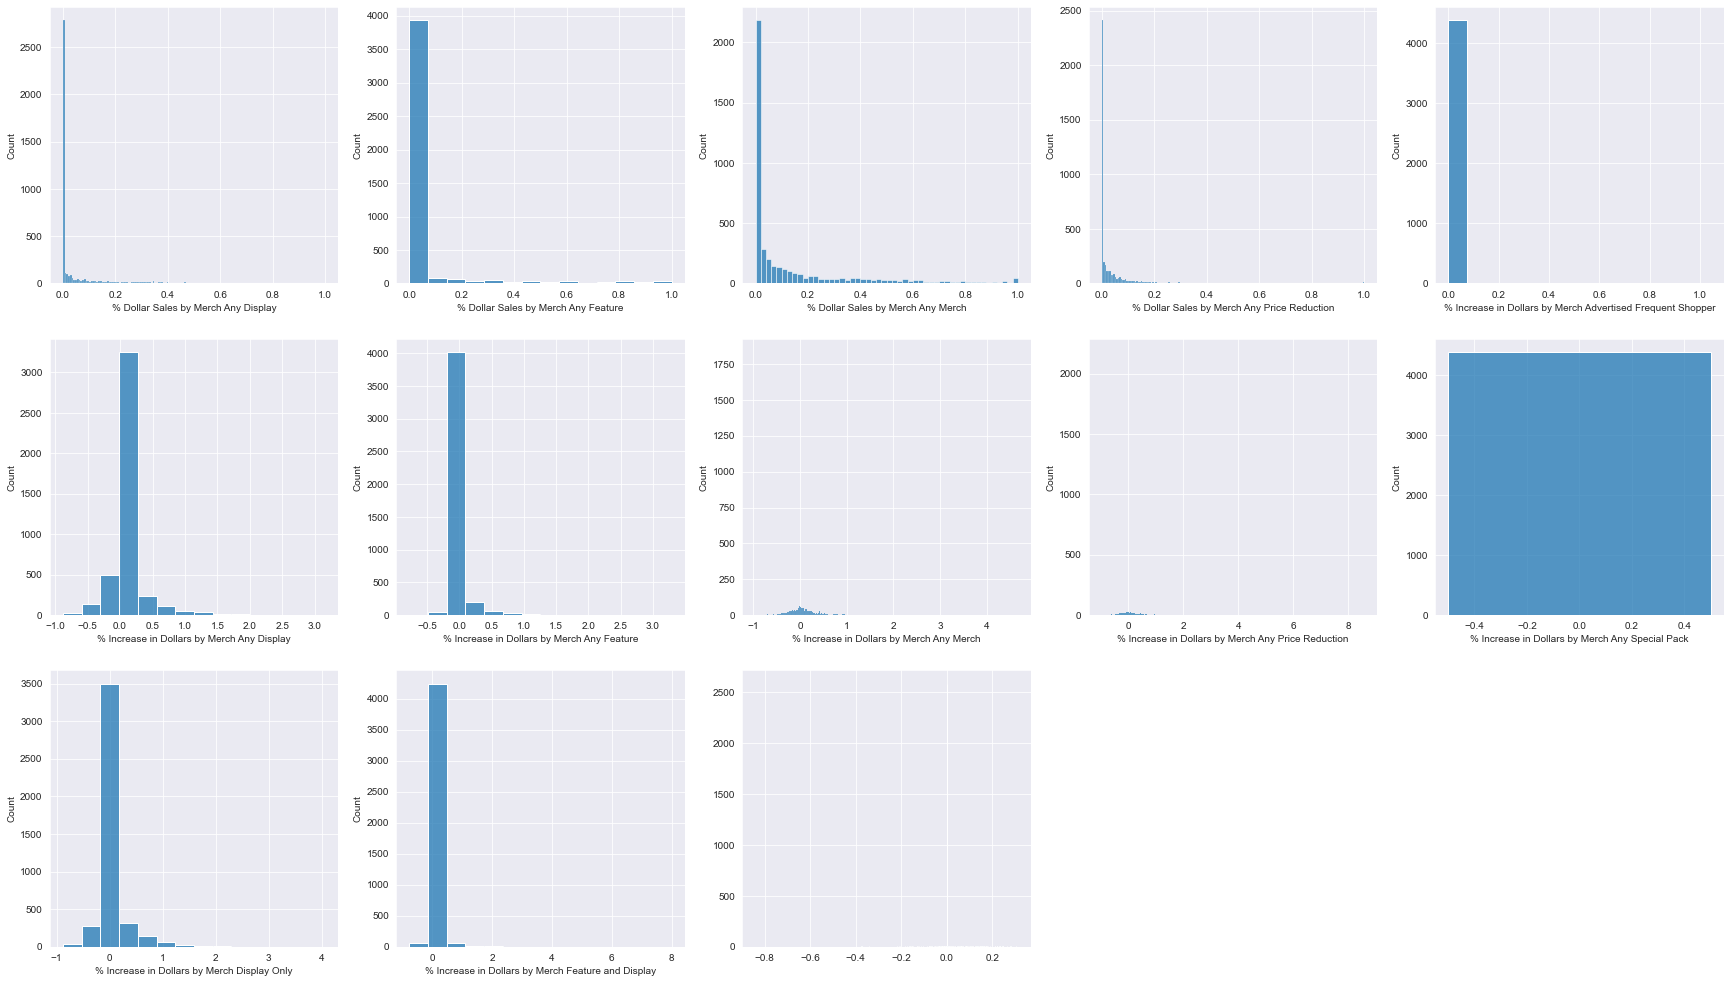

In [9]:
cols = 5
rows = 10
num_cols = df.select_dtypes(exclude='object').columns
fig = plt.figure(figsize=(cols * 6, rows * 6))
for i, col in enumerate(num_cols):
    ax = fig.add_subplot(rows, cols, i + 1)
    sns.histplot(x=df[col], ax=ax)
fig.tight_layout()
plt.show()

In [ ]:
# these visualizations provide some clue as to how to model the large number
# of variables and to examine their relationships
corr = df.corr(method="spearman")
corr.style.background_gradient(cmap="coolwarm").set_precision(2)

##### Imputation of missing values is too unreliable to base the rest of the
##### model on. Later tests will tell if there is any bias present. This is when
##### the most standout variables should be chosen for the model

In [ ]:
# print(len(df))
# df = df.dropna(how='any', subset=['Impressions per Week'])
# df['Impressions per Week'].astype('float32', copy=True)
# df = df.dropna(how='any', subset=['%ACV Distribution'])
# df['%ACV Distribution'].astype('float32', copy=True)
# df = df.dropna(how='any', subset=['Units'])
# df['Units'].astype('float32', copy=True)
# df = df.dropna(how='any', subset=['Number of UPCs Selling'])
# df['Number of UPCs Selling'].astype('float32', copy=True)
# df = df.dropna(how='any', subset=['Total Sales'])
# df['Total Sales'].astype('float32', copy=True)
# df = df.dropna(how='any', subset=['Base $'])
# df['Base $'].astype('float32', copy=True)
# print(df.describe())
# print(df.info())
# ['Impressions per Week', 'Units', '%ACV Distribution',
#  'Number of UPCs Selling', 'Base $']

In [ ]:
# most of the EDA techniques we'll use cannot handle categorical data, so dropping
# the categoricals and rerunning the correlation plot is valuable here
df_num = df.select_dtypes(exclude=object)
corr = df_num.corr()
corr.style.background_gradient(cmap="coolwarm").set_precision(2)

In [ ]:
# this is just another visualization of correlation that I like, I may switch it with others
viz = plot_corr_heatmap(df_num, figsize=(16,17))
viz.view()

In [ ]:
figure, axes = plt.subplots(2, 3, figsize=(15, 15))
sns.kdeplot(ax=axes[0, 0], x='Total Sales', data=df_num)
sns.kdeplot(ax=axes[0, 1], x='Impressions per Week', data=df_num)
sns.kdeplot(ax=axes[0, 2], x='Brand Share of Tactic Redemption Cost', data=df_num)
sns.kdeplot(ax=axes[1, 0], x='Any Promo Units', data=df_num)
sns.kdeplot(ax=axes[1, 1], x='%ACV Distribution', data=df_num)
sns.kdeplot(ax=axes[1, 2], x='Number of UPCs Selling', data=df_num)
plt.show()

### These kde plots will a primary tool in determining the likelihood
### distributions and giving information on the prior

In [ ]:
df_all = df_num.dropna().astype(dtype='int32')

features = ['Impressions per Week', 'Brand Share of Tactic Redemption Cost',
            'Any Promo Units', '%ACV Distribution', 'Number of UPCs Selling']
target = 'Total Sales'
df_all = df_all[features + [target]]
df_train, df_test = train_test_split(df_all, test_size=0.15)

X_train, y_train = df_train.drop('Total Sales',axis=1), df_train['Total Sales']
X_test, y_test = df_test.drop('Total Sales',axis=1), df_test['Total Sales']

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                            #                            max_features=X_train.shape[1]-1,
                            max_features=1.0,
                            min_samples_leaf=10, oob_score=True)
rf.fit(X_train, y_train)

In [ ]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0, warm_start=False)

### This importance plot from a RandomForestClassifier is one of the key
### ways we'll understand which variables are the most important

In [ ]:
I = importances(rf, X_test, y_test)
plot_importances(I)

#### With an array of all the variables, I could make an importance plot
#### for everything but the categorical variables, but I would have to change
#### the dependent variable each time. Remember that we dropped missing values
#### instead of dropping columns, which we could do with a column that did not
#### make an impression on the correlation plot or importance plot

In [ ]:
I = pd.DataFrame()

I['Feature'] = X_train.columns
I['Importance'] = df_all.feature_importances_
I = I.sort_values('Importance', ascending=False)
I = I.set_index('Feature')
viz = plot_importances(I)

#### Our categorical variables shouldn't be forgotten; just alter the threshold
#### down from 250 if the axis titles start to look messy

In [ ]:
for col in df.select_dtypes(include='object'):
    if df[col].nunique() <= 250:
        sns.countplot(y=col, data=df)
        plt.show()

In [ ]:
X = np.array(df_num['Total Sales'])
Y = np.array(df_num['Any Promo Units'])
Z = np.array(df_num['%ACV Distribution'])
temp = np.vstack((X, Y))
letters = (np.vstack((temp, Z))).T

# pca = PCA(n_components=3, svd_solver='full')
# plt(pca.fit(letters))

# lda = LinearDiscriminantAnalysis(n_components=2)
# X_r2 = lda.fit(X, Y).transform(X)
#
# X_r.plt()
# X_r2.plt()